# Redes Convolucionales  - Caballo vs Humano Clasificador.

## Preparación del dataset

Hay dos tipos de dataset, estan los dataset de entrenamiento y los dataset de validación, entrenar datos es para decir a la red neuronal que "Esto es lo que parece un caballo". El dataset de validación es para checkear la precisión del modelo al utilizar nuevas imagenes.

In [ ]:
# Descargar los datasets para entrenamiento
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Descargar los datasets para validación
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2024-05-23 13:50:49--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.207, 209.85.145.207, 142.250.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   172MB/s    in 0.8s    

2024-05-23 13:50:50 (172 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2024-05-23 13:50:50--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.207, 209.85.145.207, 142.250.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480

In [ ]:
import zipfile

# Extraer el dataset de entrenamiento
zip_file = zipfile.ZipFile('./horse-or-human.zip','r')
zip_file.extractall('./horse-or-human')

# Extraer el dataset de validación
zip_file = zipfile.ZipFile('./validation-horse-or-human.zip','r')
zip_file.extractall('./validation-horse-or-human')


> Los contenidos extraidos del zip estan en base al directorio ./horse-or-human para entrenamiento son ./validation-horse-or-human para checkear

## Data Augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Todas las imagenes se rescalan al 0-1, 255 como divisor, porque cada color tiene un rango entre 0 al 255 (RGB)
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

validation_datagenerator = ImageDataGenerator(rescale=1./255)

## Preprocesamiento de los Datasets
Para este dataset, no se usará una etiqueta para cada imagen como caballo o persona.

En cambio se utilizará [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) API que nos estructura automaticamente las etiquetas de las imagenes dependiendo del nombre del directorio y la estructura. Por ejemplo, tendremos un directorio conteniendo **Caballos** llamado "/Directorio/Caballos", y otro de **Personas** llamado "/Directorio/Personas".

In [ ]:
TRAINING_DIR = '/content/horse-or-human'
VALIDATION_DIR = '/content/validation-horse-or-human'



train_generator = train_datagenerator.flow_from_directory(
    TRAINING_DIR, # Directorio principal que contiene los sub directorios para las etiquetas. parent directory that contain sub directory for labels
    target_size = (300,300), # Esto hace que todos los tamaños de datos sean uniformes.
    batch_size = 128, # En cada iteración de entrenamiento, el modelo procesará 128 imagenes del dataset.
    class_mode = 'binary' # Se usa modo binario ya que en este caso se realizará una clasificación de dos clases o clases binarias.
)

validation_generator = validation_datagenerator.flow_from_directory(
    VALIDATION_DIR, # Lo mismo de arriba, pero para el dataset de validación.
    target_size = (300,300),
    batch_size = 32, # Se consideran menos imagenes para la validación, en este caso 32.
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Construir el modelo

---

### Neural Network Layers

Para el modelo de arquitectura, utilizaremos  neural network con [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layer y [Pooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer.

- Convolucion aplica un filtro a las imagenes para extraer las características más significativas
```
tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape(300,300,3))
```
El codigo de arriba es un layer de convolucion con 64 filtros, el filtro sera de 3x3 pixels en tamaño, y el input de las imagenes es de 300x300 en 3 canales de colores

- Pooling layer es usado para downscalear y espaciar las dimensiones reducidas
```
tf.keras.layers.MaxPooling2D(2,2)
```
El código de arriba elige los pixeles de mejor valor desde una grilla de 2x2 pixeles, para así capturar las características más importantes al seleccionar la respuesta máxima entre cada región de pooling (recolección de pixeles) y reduciendo las dimensiones espaciales de la característica obtenida de las capas convolucionales anteriores.

- Usamos `activation='sigmoid'` en la última capa para que el valor obtenido de la red neuronal sea un escalar de entre 0 y 1, codificando la probabilidad de que la imagen actual es de la clase 1 (opuesta a la clase 0).

---

In [ ]:
import tensorflow as tf

# Aquí podríamos explicar a grandes rasgos para qué se utiliza la librería TensorFlow

model = tf.keras.models.Sequential([

    # Primera capa de convolucion y pooling
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    # Segunda capa de convolucion y pooling
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Tercera capa de convolucion y pooling
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Cuarta capa de convolucion y pooling
    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Se utiliza la función flatten para "aplanar" las capas de convolución y pooling a 1 dimensión.
    tf.keras.layers.Flatten(),

    # Se añade un ratio de dropout de 0.2
    tf.keras.layers.Dropout(0.2),

    # Capa oculta con 128 "neuronas".
    tf.keras.layers.Dense(128, activation='relu'),

    # Capa oculta con 512 "neuronas".
    tf.keras.layers.Dense(512, activation='relu'),

    # Última capa resultante, con una neurona y una función sigmoide en donde el rango se define desde 0 a 1 porque se refiere a las probabilidades de 2 clases (0 o 1)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

---

### Pérdida y optimizador

- Para calcular la función de pérdida, usamos `loss = binary_crossentropy` porque, como dijimos anteriormente, el caso es un tipo de clasificación binaria.

- Para optimizar, usamos [RMSprob optimization algorithm](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) con un ratio de aprendizaje de 0.0001.

---

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(learning_rate = 0.0001),
              metrics = ['accuracy'])

### Entrenamiento del Modelo

Podemos observar que tan rapido se entrena el modelo y las precisiones que obtenemos tanto del dataset de entrenamiento como del dataset de validación.

In [ ]:
history_cnn = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=25,
      verbose=2,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/25
8/8 - 49s - loss: 0.6895 - accuracy: 0.5284 - val_loss: 0.6952 - val_accuracy: 0.5000 - 49s/epoch - 6s/step
Epoch 2/25
8/8 - 29s - loss: 0.6871 - accuracy: 0.5312 - val_loss: 0.6896 - val_accuracy: 0.5000 - 29s/epoch - 4s/step
Epoch 3/25
8/8 - 27s - loss: 0.6726 - accuracy: 0.5962 - val_loss: 0.6787 - val_accuracy: 0.5000 - 27s/epoch - 3s/step
Epoch 4/25
8/8 - 26s - loss: 0.6613 - accuracy: 0.6263 - val_loss: 0.6645 - val_accuracy: 0.5000 - 26s/epoch - 3s/step
Epoch 5/25
8/8 - 26s - loss: 0.6408 - accuracy: 0.6329 - val_loss: 0.7701 - val_accuracy: 0.5000 - 26s/epoch - 3s/step
Epoch 6/25
8/8 - 26s - loss: 0.6122 - accuracy: 0.6919 - val_loss: 0.8319 - val_accuracy: 0.5000 - 26s/epoch - 3s/step
Epoch 7/25
8/8 - 26s - loss: 0.6226 - accuracy: 0.6752 - val_loss: 0.6980 - val_accuracy: 0.5039 - 26s/epoch - 3s/step
Epoch 8/25
8/8 - 26s - loss: 0.6336 - accuracy: 0.6785 - val_loss: 0.6994 - val_accuracy: 0.5078 - 26s/epoch - 3s/step
Epoch 9/25
8/8 - 27s - loss: 0.5726 - accuracy: 

---

## Aprendizaje por transferencia

Para mejorar aún más el rendimiento de la clasificación, vamos a implementar el aprendizaje por transferencia desde el modelo InceptionV3.

InceptionV3 es una arquitectura de red neuronal convolucional profunda pre-entrenada en un dataset de gran escala, que incluye muchas categorías de objetos.

---

### Descargar los weights preentrenados

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-23 14:34:49--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   271MB/s    in 0.3s    

2024-05-23 14:34:49 (271 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



### Configuramos el modelo
Se crea el modelo pre entrenado con:

- `include_top = False` que significa que la primera capa de clasificación se excluye o se ignora.

- `weights = None` que significa que ignora los weights del modelo pre entrenado.

Ahora, los weights (o pesos) pre entrenados se cargan en el `pretrained_model` llamando a los `load_weights` y agregando la dirección al archivo de los weights.

Finalmente, las capas del modelo se congelan al configurar el parametro `layer.trainable = False` para cada capa en el `pretrained_model`.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

transfer_file ='/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(input_shape=(300,300,3),
                               include_top = False,
                               weights = None)

# Load the pre-trained weights you downloaded.
pretrained_model.load_weights(transfer_file)

# Freeze the weights of the layers.
for layer in pretrained_model.layers:
  layer.trainable = False

### Definir el nuevo modelo

No usaremos el modelo pre-entrenado completo, en cambio, usaremos la capa `"mixed7"` como última capa para seguir procesando.

In [ ]:
# Aquí elegimos `mixed_7` como última capa de nuestro modelo base.
layer_name = 'mixed7'
last_layer = pretrained_model.get_layer(layer_name)
print(f'{layer_name} layer output shape: {last_layer.output_shape}')
last_output = last_layer.output

mixed7 layer output shape: (None, 17, 17, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Aplanamos la capa resultante a 1 sola dimensión
x = layers.Flatten()(last_output)

# Anadimos una capa completamente conectada con 1024 unidades ocultas y activación ReLU (Qué es esto?)
x = layers.Dense(1024, activation='relu')(x)

# Se agrega un ratio de dropout de 0.2
x = layers.Dropout(0.2)(x)

# Se agrega una capa sigmoide final para la clasificación
x = layers.Dense  (1, activation='sigmoid')(x)

# Se anexsa la red densa al modelo base
model = Model(pretrained_model.input, x)

### Pérdida, optimizador y entrenamiento
Usaremos los mismos parametros de perdida, optimización y entrenamiento que nuestro anterior modelo CNN.

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(learning_rate = 0.00015),
              metrics = ['accuracy'])

history_inception = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=25,
      verbose=2,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/25
8/8 - 42s - loss: 5.3052 - accuracy: 0.5762 - val_loss: 0.8257 - val_accuracy: 0.8047 - 42s/epoch - 5s/step
Epoch 2/25
8/8 - 26s - loss: 0.0457 - accuracy: 0.9867 - val_loss: 0.3608 - val_accuracy: 0.8984 - 26s/epoch - 3s/step
Epoch 3/25
8/8 - 26s - loss: 0.0330 - accuracy: 0.9911 - val_loss: 0.2067 - val_accuracy: 0.9219 - 26s/epoch - 3s/step
Epoch 4/25
8/8 - 27s - loss: 0.0185 - accuracy: 0.9956 - val_loss: 0.2598 - val_accuracy: 0.9141 - 27s/epoch - 3s/step
Epoch 5/25
8/8 - 26s - loss: 0.0127 - accuracy: 0.9989 - val_loss: 0.3583 - val_accuracy: 0.8984 - 26s/epoch - 3s/step
Epoch 6/25
8/8 - 26s - loss: 0.1356 - accuracy: 0.9600 - val_loss: 3.4382 - val_accuracy: 0.5000 - 26s/epoch - 3s/step
Epoch 7/25
8/8 - 29s - loss: 0.6595 - accuracy: 0.8848 - val_loss: 0.2790 - val_accuracy: 0.9102 - 29s/epoch - 4s/step
Epoch 8/25
8/8 - 29s - loss: 0.0146 - accuracy: 0.9971 - val_loss: 0.2600 - val_accuracy: 0.9180 - 29s/epoch - 4s/step
Epoch 9/25
8/8 - 26s - loss: 0.0124 - accuracy: 

## Model Comparison

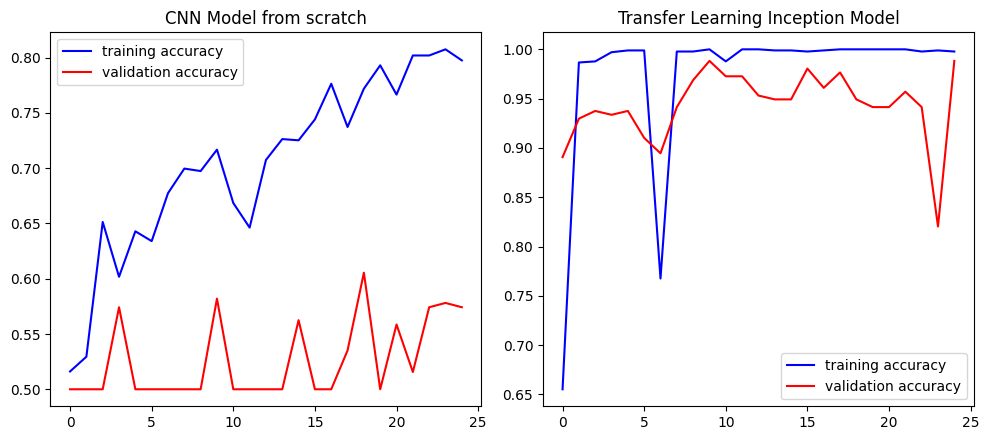

In [ ]:
import matplotlib.pyplot as plt


acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

acc_inception = history_inception.history['accuracy']
val_acc_inception= history_inception.history['val_accuracy']

epochs = range(len(acc_cnn))

# Se grafican los modelos para compararlos (acc del de entrenamiento vs acc del de validación)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))

# Se grafica el modelo CNN en el primer subgrafico
axes[0].plot(epochs, acc_cnn, color= 'blue', label = 'training accuracy')
axes[0].plot(epochs, val_acc_cnn, color= 'red', label = 'validation accuracy')
axes[0].set_title('CNN Model from scratch')
axes[0].legend()

# Se grafica el modelo en base a InceptionV3 en el segundo subgrafico
axes[1].plot(epochs, acc_inception, color= 'blue', label = 'training accuracy')
axes[1].plot(epochs, val_acc_inception, color= 'red', label = 'validation accuracy')
axes[1].set_title('Transfer Learning Inception Model')
axes[1].legend()

plt.tight_layout()

plt.show()


Después de entrenar los modelos durante 25 iteraciones, se puede concluir que el modelo de aprendizaje por transferencia da mejores resultados tanto en precisión de entrenamiento como en precisión de validación comparado a entrenar los modelos desde cero. La conclusión se basa en el analisis del comportamiento de la precisión de entrenamiento y validación a lo largo de las 25 iteraciones.

Al usar el aprendizaje por transferencia, el de modelos pre-entrenados como lo son InceptionV3, los modelos se benefician de las características de aprendizaje y representaciones de datasets muy grandes. Esto, permite a los modelos alcanzar una mayor precisión durante el entrenamiento y una generalizacion con respecto al dataset de validación.

## Predicción en base al modelo
Después de que se termina el modelo, podemos usarlo para predecir imagenes que subamos.


Saving horse-3.jpg to horse-3.jpg


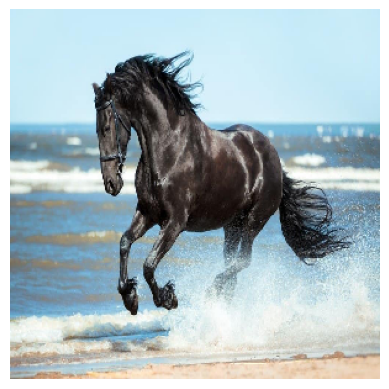

1/1 [==============================] - 0s 35ms/step
[1.4870852e-05]
horse-3.jpg is a horse



In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():

  # Predecir imagenes
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
  print()